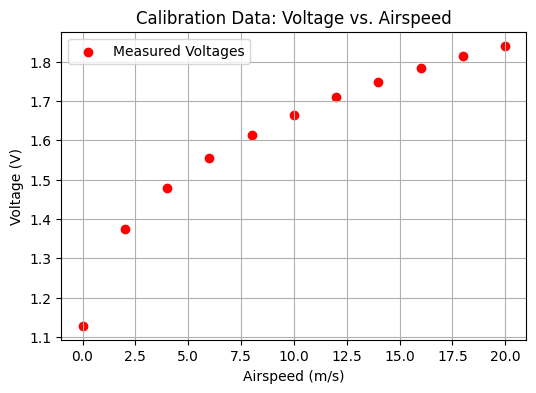

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial
import os

# Directory containing the data
folder_path = '../HWA_data'  # Adjust based on the actual relative path
folder_path = os.path.normpath(folder_path)  # Normalize path

# Read and process each calibration file
velocities = np.arange(0, 21, 2)  # Velocity steps from 0 to 20 m/s
voltage_means = []

for speed in velocities:
    file_name = f'Calibration_{speed:03d}.txt'          # Format the filename
    file_path = os.path.join(folder_path, file_name)
    try:
        data = pd.read_csv(file_path, sep="\t", skiprows=24, header=None, names=['Time', 'Voltage'])
        voltage_mean = data['Voltage'].mean()
        voltage_means.append(voltage_mean)
    except FileNotFoundError:
        print(f"File not found: {file_name}")
        voltage_means.append(np.nan)  # Append NaN for missing files

# Remove NaN values in case some files were missing
valid_indices = ~np.isnan(voltage_means)
valid_velocities = velocities[valid_indices]
valid_voltage_means = np.array(voltage_means)[valid_indices]

# Plotting the calibration data
plt.figure(figsize=(6, 4))
plt.scatter(valid_velocities, valid_voltage_means, color='red', label='Measured Voltages')
plt.title('Calibration Data: Voltage vs. Airspeed')
plt.xlabel('Airspeed (m/s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()
plt.show()

[]


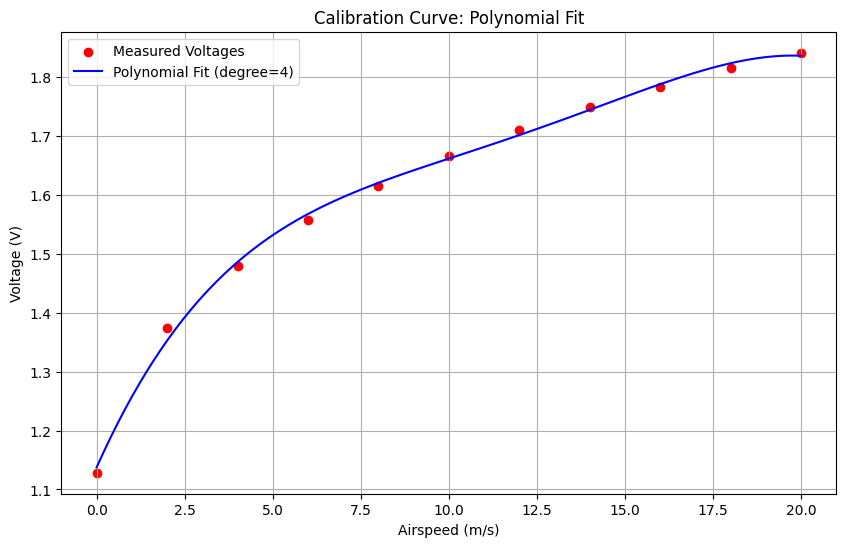

Degree: 4             Polynomial Coefficients: [ 1.13753702e+00  1.33538534e-01 -1.46236574e-02  8.16635079e-04
 -1.66024270e-05]


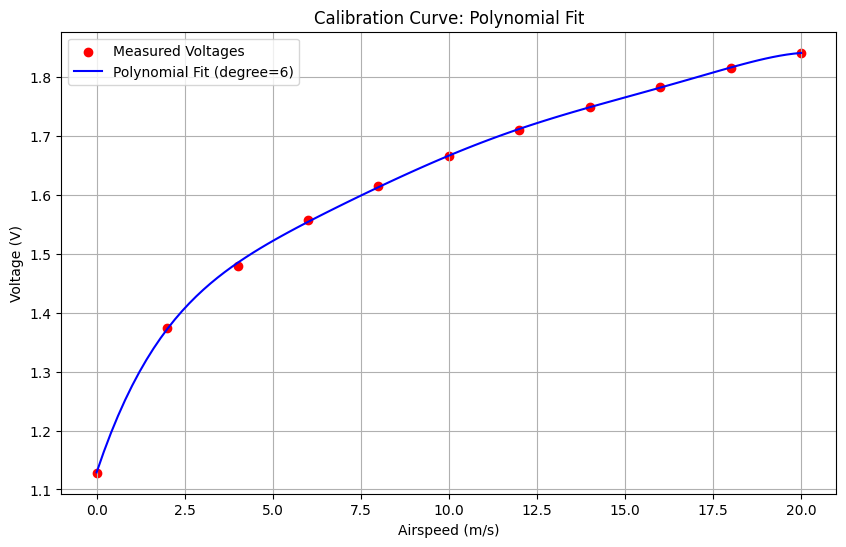

Degree: 6             Polynomial Coefficients: [ 1.12899748e+00  1.78629569e-01 -3.70211652e-02  4.83532512e-03
 -3.45227758e-04  1.24924332e-05 -1.79292932e-07]


In [38]:
# Fit a polynomial to the voltage data
degrees = [4,6]
coeff = []
print(coeff)
for i,degree in enumerate(degrees):
    coeff.append(Polynomial.fit(valid_velocities, valid_voltage_means, deg=degree))

    # Plot the fit
    x_fit = np.linspace(0, 20, 100)
    y_fit = coeff[i](x_fit)

    plt.figure(figsize=(10, 6))
    plt.scatter(valid_velocities, valid_voltage_means, color='red', label='Measured Voltages')
    plt.plot(x_fit, y_fit, label=f'Polynomial Fit (degree={degree})', color='blue')
    plt.title('Calibration Curve: Polynomial Fit')
    plt.xlabel('Airspeed (m/s)')
    plt.ylabel('Voltage (V)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Output the coefficients
    print(f'Degree:',degree,"            Polynomial Coefficients:", coeff[i].convert().coef)

In [37]:
def voltage_to_airspeed(voltage, coeffs):
    """
    Convert a measured voltage to an airspeed using polynomial coefficients.
    
    Parameters:
    - voltage (float): The voltage measured by the hot-wire anemometer.
    - coeffs (list): List of polynomial coefficients, [c0, c1, c2, ...], where
                     P(x) = c0 + c1*x + c2*x^2 + ...

    Returns:
    - float: Estimated airspeed corresponding to the measured voltage.
    """
    airspeed = np.polyval(coeffs[::-1], voltage)  # coeffs should be in decreasing order for np.polyval
    return airspeed


for polynomial_coefficients in coeff:
    polynomial_coefficients.convert().coef
    estimated_airspeed = voltage_to_airspeed(voltage_means, polynomial_coefficients)
    print(f"Estimated Airspeed: {estimated_airspeed:.2f} m/s")

TypeError: 'Polynomial' object is not subscriptable

In [4]:
# Correct polynomial coefficients
actual_coeffs = [-0.0003, 0.0063, 1.2]  # Example actual coefficients from your calibration
measured_voltage = 1.5
estimated_airspeed = voltage_to_airspeed(measured_voltage, actual_coeffs)
print(f"Accurate Estimated Airspeed: {estimated_airspeed:.2f} m/s")

Accurate Estimated Airspeed: 2.71 m/s


Includes spline fitting


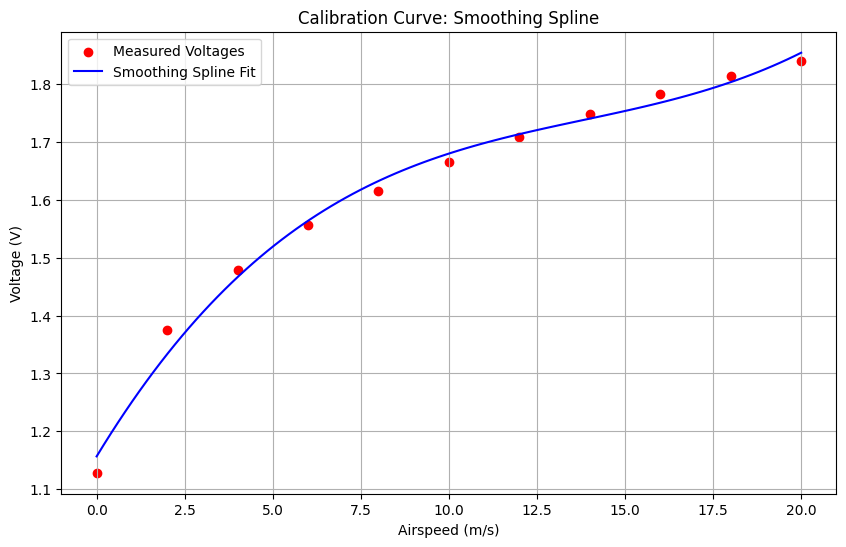

Smoothing spline coefficients: [1.15666302 1.82555422 1.6514529  1.85466302]
Knots of the spline: [ 0. 20.]


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Directory containing the data
folder_path = '../HWA_data'  # Adjust based on the actual relative path
folder_path = os.path.normpath(folder_path)  # Normalize path

# Read and process each calibration file
velocities = np.arange(0, 22, 2)  # Velocity steps from 0 to 20 m/s
voltage_means = []

for speed in velocities:
    file_name = f'Calibration_{speed:03d}.txt'  # Format the filename
    file_path = os.path.join(folder_path, file_name)
    try:
        data = pd.read_csv(file_path, sep="\t", skiprows=24, header=None, names=['Time', 'Voltage'])
        voltage_mean = data['Voltage'].mean()
        voltage_means.append(voltage_mean)
    except FileNotFoundError:
        print(f"File not found: {file_name}")
        voltage_means.append(np.nan)  # Append NaN for missing files

# Remove NaN values in case some files were missing
valid_indices = ~np.isnan(voltage_means)
valid_velocities = velocities[valid_indices]
valid_voltage_means = np.array(voltage_means)[valid_indices]

# Fit a smoothing spline
spline = UnivariateSpline(valid_velocities, valid_voltage_means, s=1)  # 's' is a smoothing factor; adjust as needed

# Generate values for plotting
x_smooth = np.linspace(0, 20, 100)
y_smooth = spline(x_smooth)

# Plotting the calibration data
plt.figure(figsize=(10, 6))
plt.scatter(valid_velocities, valid_voltage_means, color='red', label='Measured Voltages')
plt.plot(x_smooth, y_smooth, label='Smoothing Spline Fit', color='blue')
plt.title('Calibration Curve: Smoothing Spline')
plt.xlabel('Airspeed (m/s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.show()

# Optional: Print smoothing spline coefficients or details if necessary
print("Smoothing spline coefficients:", spline.get_coeffs())
print("Knots of the spline:", spline.get_knots())

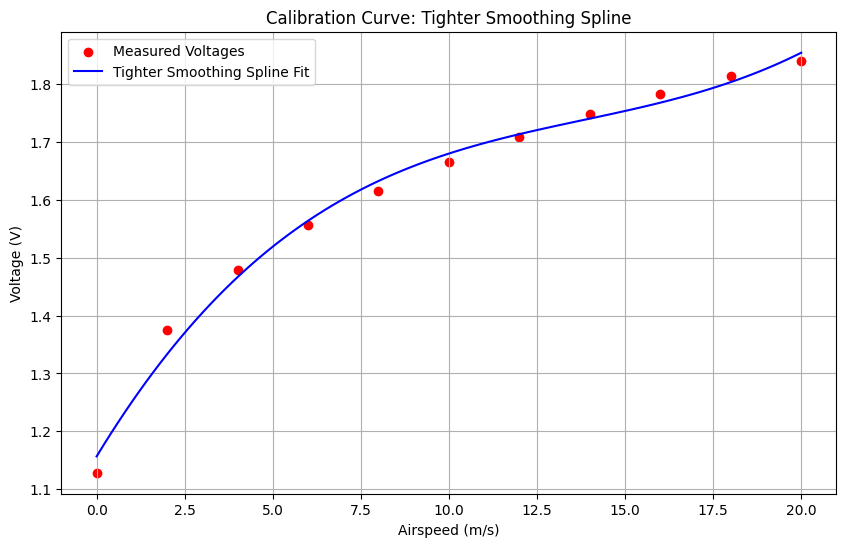

In [7]:
# Fit a smoothing spline with a smaller smoothing factor
spline_tight = UnivariateSpline(valid_velocities, valid_voltage_means, s=0.1)  # Adjust 's' as needed

# Generate values for plotting
x_smooth_tight = np.linspace(0, 20, 100)
y_smooth_tight = spline_tight(x_smooth_tight)

# Plotting the calibration data
plt.figure(figsize=(10, 6))
plt.scatter(valid_velocities, valid_voltage_means, color='red', label='Measured Voltages')
plt.plot(x_smooth_tight, y_smooth_tight, label='Tighter Smoothing Spline Fit', color='blue')
plt.title('Calibration Curve: Tighter Smoothing Spline')
plt.xlabel('Airspeed (m/s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.grid(True)
plt.show()